Well-Conditioned Quadratic Function 

 10-dimensional Q matrix with condition number: 10.00
 starting vector X0. Initial Loss: 6.103e+01

--- Starting MSAM (RMSM) ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Goal reached by MSAM (RMSM) in 2542 iterations.

--- Starting Adam (Code 1 Params) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-07
Goal reached by Adam (Code 1 Params) in 6550 iterations.

--- Starting AdaDelta (Code 1 Params) ---
    LR=0.001, Rho=0.9, Epsilon=1e-06
Iteration 50000: Loss = 0.688851425
Goal reached by AdaDelta (Code 1 Params) in 69085 iterations.

--- Starting SGD-M (Code 1 Params) ---
    LR=0.001, Momentum=0.9
Goal reached by SGD-M (Code 1 Params) in 6256 iterations.
 RESULTS (D=10, Cond=10.0, Target Loss < 1e-06)
MSAM (LR=0.001, B2=0.99) Iterations: 2542
Adam (LR=0.001, E=1e-07) Iterations: 6550
AdaDelta (LR=0.001, Rho=0.9) Iterations: 69085
SGD-Momentum (LR=0.001, Mom=0.9) Iterations: 6256


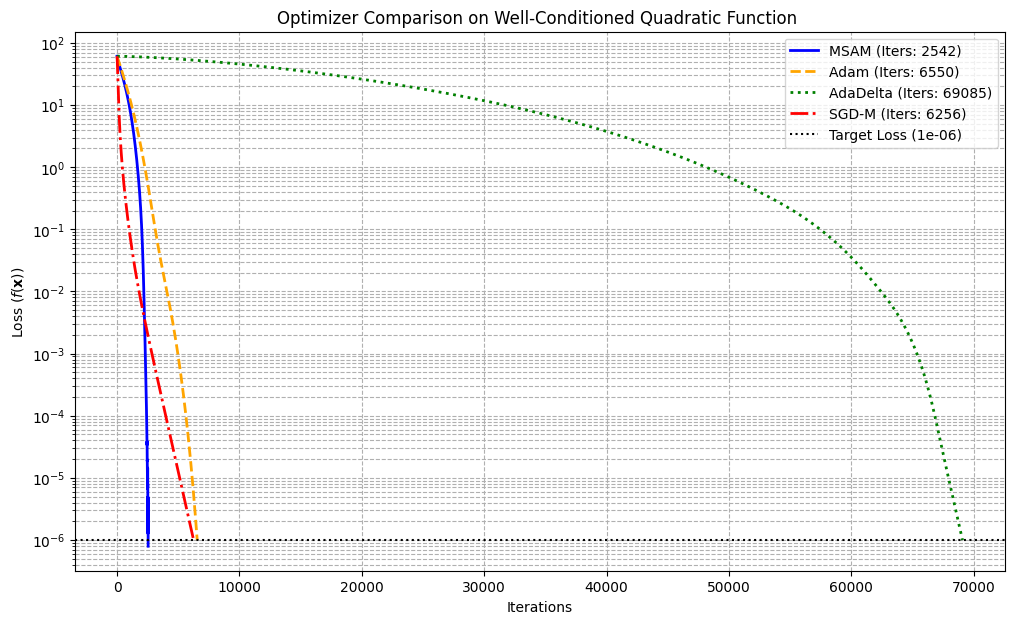

In [35]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8


ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.999)
ADAM_DEFAULT_EPS = 1e-7 


ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6


SGD_MOM_DEFAULT_LR = 0.001 # 
SGD_MOM_DEFAULT_MOMENTUM = 0.9

DIMENSION = 10
CONDITION_NUMBER = 10.0
TARGET_LOSS = 1e-6
MAX_ITERS = 200000 

def create_quadratic_problem(dim, condition_num):
   
    s_max = condition_num
    s_min = 1.0 
    
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

   
    U, _ = np.linalg.qr(np.random.randn(dim, dim))
    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2
    
    cond = np.linalg.cond(Q)
    print(f" {dim}-dimensional Q matrix with condition number: {cond:.2f}")
    
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)

def quadratic_function_high_dim(x):
    return 0.5 * x.T @ Q_MATRIX @ x

def quadratic_gradient(x):
    return Q_MATRIX @ x

X0 = np.random.randn(DIMENSION)
print(f" starting vector X0. Initial Loss: {quadratic_function_high_dim(X0):.3e}")

def setup_msam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adadelta(lr, dim, **kwargs):
    rho = kwargs['rho']
    eps = kwargs['eps']
    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        return x - lr * scaled_grad
    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    momentum = kwargs['momentum']
    v = np.zeros(dim)
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + (1.0 - momentum) * grad
        v = v_new
        
        return x - lr * v_new
    return update

def optimization_run(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):

    x = initial_x.copy()
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)
    loss_history = []
    print(f"\n--- Starting {optimizer_name} ---")
    
    if optimizer_name.startswith("AdaDelta"):
        print(f"    LR={lr}, Rho={kwargs.get('rho', ADADELTA_DEFAULT_RHO)}, Epsilon={kwargs.get('eps', ADADELTA_DEFAULT_EPS)}")
    elif optimizer_name.startswith("SGD"):
        print(f"    LR={lr}, Momentum={kwargs.get('momentum', SGD_MOM_DEFAULT_MOMENTUM)}")
    else:
        betas = kwargs.get('betas', ADAM_DEFAULT_BETAS)
        eps = kwargs.get('eps', ADAM_DEFAULT_EPS)
        print(f"    LR={lr}, Beta1={betas[0]}, Beta2={betas[1]}, Epsilon={eps}")

    for iteration in range(max_iters):
        loss = quadratic_function_high_dim(x)
        
        loss_history.append(loss)

        if loss < target_loss:
            print(f"Goal reached by {optimizer_name} in {iteration + 1} iterations.")
            return iteration + 1, loss_history

        grad = quadratic_gradient(x)
        x = optimizer_update_func(x, grad)

        if (iteration + 1) % 50000 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss:.9f}")

    print(f"Optimization run for {optimizer_name} failed to reach goal within {max_iters} iterations; final loss = {loss:.3e}")
    return max_iters, loss_history


results = {}


results['MSAM'] = optimization_run(
    optimizer_setup=setup_msam,
    optimizer_name="MSAM (RMSM)",
    lr=CUSTOM_LR,
    initial_x=X0,
    betas=CUSTOM_BETAS,
    eps=CUSTOM_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['Adam'] = optimization_run(
    optimizer_setup=setup_adam,
    optimizer_name="Adam (Code 1 Params)",
    lr=ADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=ADAM_DEFAULT_BETAS, 
    eps=ADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['AdaDelta'] = optimization_run(
    optimizer_setup=setup_adadelta,
    optimizer_name="AdaDelta (Code 1 Params)",
    lr=ADADELTA_DEFAULT_LR, 
    initial_x=X0,
    rho=ADADELTA_DEFAULT_RHO, 
    eps=ADADELTA_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['SGD-Momentum'] = optimization_run(
    optimizer_setup=setup_sgd_momentum,
    optimizer_name="SGD-M (Code 1 Params)",
    lr=SGD_MOM_DEFAULT_LR, 
    initial_x=X0,
    momentum=SGD_MOM_DEFAULT_MOMENTUM,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)


print(f" RESULTS (D={DIMENSION}, Cond={CONDITION_NUMBER:.1f}, Target Loss < {TARGET_LOSS:.0e})")

msam_iters = results['MSAM'][0]
adam_iters = results['Adam'][0]
adadelta_iters = results['AdaDelta'][0]
sgd_mom_iters = results['SGD-Momentum'][0]

print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Iterations: {msam_iters}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, E={ADAM_DEFAULT_EPS}) Iterations: {adam_iters}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Iterations: {adadelta_iters}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Mom={SGD_MOM_DEFAULT_MOMENTUM}) Iterations: {sgd_mom_iters}")


plt.figure(figsize=(12, 7))

iters_msam = list(range(1, len(results['MSAM'][1]) + 1))
plt.plot(iters_msam, results['MSAM'][1], 
           label=f'MSAM (Iters: {msam_iters})', linewidth=2, color='blue')

iters_adam = list(range(1, len(results['Adam'][1]) + 1))
plt.plot(iters_adam, results['Adam'][1], 
           label=f'Adam (Iters: {adam_iters})', linestyle='--', linewidth=2, color='orange')

iters_adadelta = list(range(1, len(results['AdaDelta'][1]) + 1))
plt.plot(iters_adadelta, results['AdaDelta'][1], 
           label=f'AdaDelta (Iters: {adadelta_iters})', linestyle=':', linewidth=2, color='green')

iters_sgd_mom = list(range(1, len(results['SGD-Momentum'][1]) + 1))
plt.plot(iters_sgd_mom, results['SGD-Momentum'][1], 
           label=f'SGD-M (Iters: {sgd_mom_iters})', linestyle='-.', linewidth=2, color='red')


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss ({TARGET_LOSS:.0e})')
plt.xlabel("Iterations")
plt.ylabel("Loss ($f(\\mathbf{x})$)")
plt.title(f"Optimizer Comparison on Well-Conditioned Quadratic Function ")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

Ill Conditioned Quadractic Function 

 10-dimensional Q matrix with condition number: 50.00
 starting vector X0. Initial Loss: 5.770e+00

--- Starting MSAM ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Goal reached by MSAM in 2701 iterations.

--- Starting Adam (Default) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-08
Iteration 5000: Loss = 0.000549435
Goal reached by Adam (Default) in 8465 iterations.

--- Starting AdaDelta (Default) ---
    LR=0.001, Rho=0.9, Epsilon=1e-06
Iteration 5000: Loss = 5.203294602
Iteration 10000: Loss = 4.309714758
Iteration 15000: Loss = 3.354144275
Iteration 20000: Loss = 2.464177563
Optimization run for AdaDelta (Default) failed to reach goal within 20000 iterations.

--- Starting SGD-Momentum (Default) ---
    LR=0.001, Momentum=0.9
Iteration 5000: Loss = 0.000812825
Iteration 10000: Loss = 0.000109533
Iteration 15000: Loss = 0.000014767
Iteration 20000: Loss = 0.000001991
Optimization run for SGD-Momentum (Default) failed to reach goal within 20000 iterations.
ILL-CONDITI

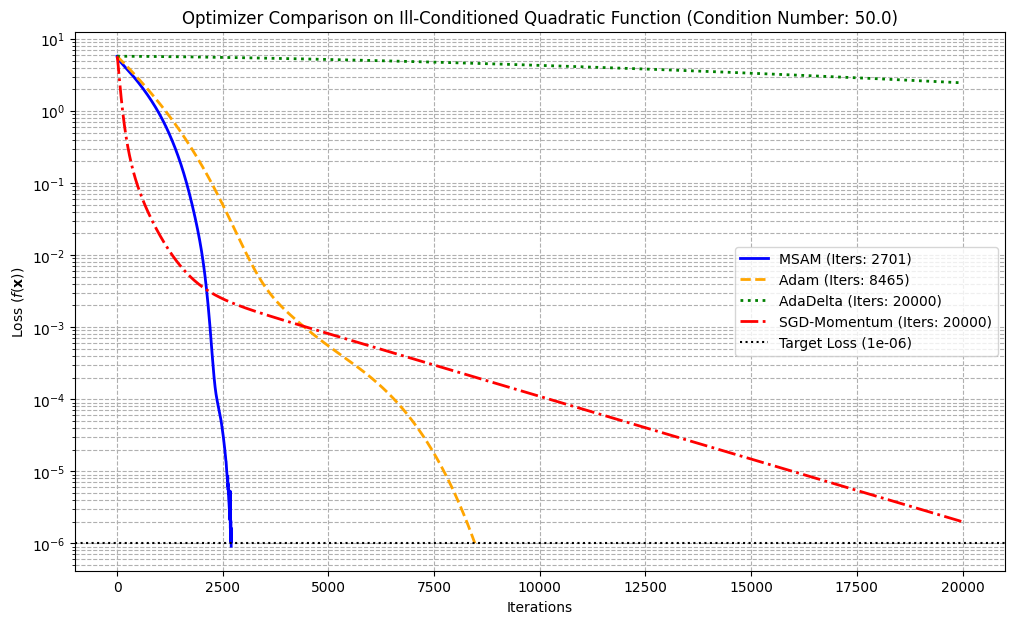

In [36]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)

CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.999)
ADAM_DEFAULT_EPS = 1e-8 

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001
SGD_MOM_DEFAULT_MOMENTUM = 0.9

DIMENSION = 10
CONDITION_NUMBER = 50.0 # Ill-conditioned
TARGET_LOSS = 1e-6
MAX_ITERS = 20000 

def create_quadratic_problem(dim, condition_num):

    s_max = 1.0
    s_min = s_max / condition_num
    
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

    U, _ = np.linalg.qr(np.random.randn(dim, dim))


    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2
    
    cond = np.linalg.cond(Q)
    print(f" {dim}-dimensional Q matrix with condition number: {cond:.2f}")
    
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)

X0 = np.random.randn(DIMENSION)
print(f" starting vector X0. Initial Loss: {quadratic_function_high_dim(X0):.3e}")

def quadratic_function_high_dim(x):
    # f(x) = 0.5 * x^T @ Q @ x
    return 0.5 * x.T @ Q_MATRIX @ x

def quadratic_gradient(x):
    # grad(f(x)) = Q @ x
    return Q_MATRIX @ x


def setup_msam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        
        m = m_new
        v = v_new
        
        return x - update_step

    return update

def setup_adam(lr, dim, **kwargs):

    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        
        m = m_new
        v = v_new
        
        return x - update_step

    return update

def setup_adadelta(lr, dim, **kwargs):
    rho = kwargs['rho']
    eps = kwargs['eps']

   
    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        
        return x - lr * scaled_grad

    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    momentum = kwargs['momentum']
    v = np.zeros(dim) 
    
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + lr * grad
        v = v_new
        return x - v_new

    return update



def optimization_run(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):

    x = initial_x.copy()
    
    
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)

    loss_history = []
    
    print(f"\n--- Starting {optimizer_name} ---")
    
 
    if optimizer_name.startswith("AdaDelta"):
        print(f"    LR={lr}, Rho={kwargs.get('rho', ADADELTA_DEFAULT_RHO)}, Epsilon={kwargs.get('eps', ADADELTA_DEFAULT_EPS)}")
    elif optimizer_name.startswith("SGD"):
        print(f"    LR={lr}, Momentum={kwargs.get('momentum', SGD_MOM_DEFAULT_MOMENTUM)}")
    else:
        betas = kwargs.get('betas', ADAM_DEFAULT_BETAS)
        eps = kwargs.get('eps', ADAM_DEFAULT_EPS)
        print(f"    LR={lr}, Beta1={betas[0]}, Beta2={betas[1]}, Epsilon={eps}")

    for iteration in range(max_iters):
        loss = quadratic_function_high_dim(x)
        
        loss_history.append(loss)

        if loss < target_loss:
            print(f"Goal reached by {optimizer_name} in {iteration + 1} iterations.")
            return iteration + 1, loss_history

        grad = quadratic_gradient(x)
        
      
        x = optimizer_update_func(x, grad)

        if (iteration + 1) % 5000 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss:.9f}")

    print(f"Optimization run for {optimizer_name} failed to reach goal within {max_iters} iterations.")
    return max_iters, loss_history


results = {}


results['MSAM'] = optimization_run(
    optimizer_setup=setup_msam,
    optimizer_name="MSAM",
    lr=CUSTOM_LR,
    initial_x=X0,
    betas=CUSTOM_BETAS,
    eps=CUSTOM_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)


results['Adam'] = optimization_run(
    optimizer_setup=setup_adam,
    optimizer_name="Adam (Default)",
    lr=ADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=ADAM_DEFAULT_BETAS, 
    eps=ADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['AdaDelta'] = optimization_run(
    optimizer_setup=setup_adadelta,
    optimizer_name="AdaDelta (Default)",
    lr=ADADELTA_DEFAULT_LR, 
    initial_x=X0,
    rho=ADADELTA_DEFAULT_RHO, 
    eps=ADADELTA_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['SGD-Momentum'] = optimization_run(
    optimizer_setup=setup_sgd_momentum,
    optimizer_name="SGD-Momentum (Default)",
    lr=SGD_MOM_DEFAULT_LR, 
    initial_x=X0,
    momentum=SGD_MOM_DEFAULT_MOMENTUM,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

print(f"ILL-CONDITIONED Quadratic Optimization Results (D={DIMENSION}, Cond={CONDITION_NUMBER:.1f}, Target Loss < {TARGET_LOSS:.0e})")



msam_iters = results['MSAM'][0]
adam_iters = results['Adam'][0]
adadelta_iters = results['AdaDelta'][0]
sgd_mom_iters = results['SGD-Momentum'][0]

print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Iterations to Goal: {msam_iters}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Iterations to Goal: {adam_iters}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Iterations to Goal: {adadelta_iters}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Momentum={SGD_MOM_DEFAULT_MOMENTUM}) Iterations to Goal: {sgd_mom_iters}")


plt.figure(figsize=(12, 7))

iters_msam = list(range(1, len(results['MSAM'][1]) + 1))
plt.plot(iters_msam, results['MSAM'][1], 
            label=f'MSAM (Iters: {msam_iters})', linewidth=2, color='blue')

iters_adam = list(range(1, len(results['Adam'][1]) + 1))
plt.plot(iters_adam, results['Adam'][1], 
            label=f'Adam (Iters: {adam_iters})', linestyle='--', linewidth=2, color='orange')

iters_adadelta = list(range(1, len(results['AdaDelta'][1]) + 1))
plt.plot(iters_adadelta, results['AdaDelta'][1], 
            label=f'AdaDelta (Iters: {adadelta_iters})', linestyle=':', linewidth=2, color='green')

iters_sgd_mom = list(range(1, len(results['SGD-Momentum'][1]) + 1))
plt.plot(iters_sgd_mom, results['SGD-Momentum'][1], 
            label=f'SGD-Momentum (Iters: {sgd_mom_iters})', linestyle='-.', linewidth=2, color='red')


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss ({TARGET_LOSS:.0e})')
plt.xlabel("Iterations")
plt.ylabel("Loss ($f(\\mathbf{x})$)")
plt.title(f"Optimizer Comparison on Ill-Conditioned Quadratic Function (Condition Number: {CONDITION_NUMBER:.1f})")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

Rosenbrock Function 

Initial Loss (at -1.2, 1.0): 24.200

--- Starting MSAM ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Iteration 500: Loss = 4.149422
Iteration 1000: Loss = 3.335837
Iteration 1500: Loss = 1.919435
Iteration 2000: Loss = 0.655691
Iteration 2500: Loss = 0.149316
Iteration 3000: Loss = 0.006664
Goal reached by MSAM in 3259 iterations.
Final coordinates: x=0.9900, y=0.9801

--- Starting Adam (Default) ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Iteration 500: Loss = 4.205237
Iteration 1000: Loss = 3.604612
Iteration 1500: Loss = 2.328806
Iteration 2000: Loss = 0.869460
Iteration 2500: Loss = 0.239115
Iteration 3000: Loss = 0.018567
Goal reached by Adam (Default) in 3371 iterations.
Final coordinates: x=0.9901, y=0.9802

--- Starting AdaDelta (Default) ---
    LR=0.001, Rho=0.9, Epsilon=1e-06
Iteration 500: Loss = 23.319591
Iteration 1000: Loss = 22.004196
Iteration 1500: Loss = 20.456130
Iteration 2000: Loss = 18.787817
Iteration 2500: Loss = 17.078855
Iteration 3000: Lo

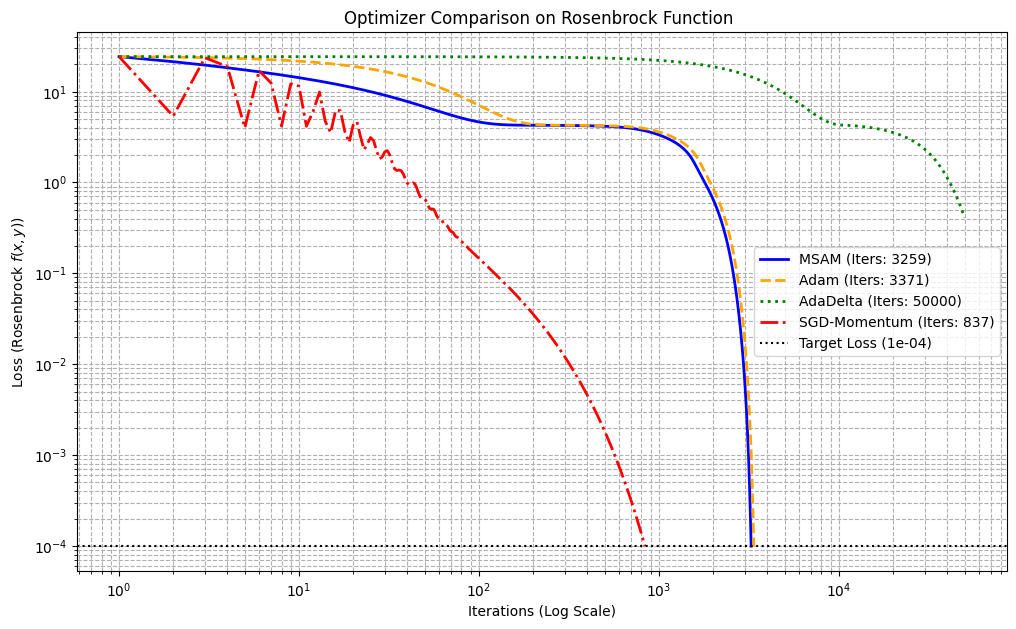

In [40]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)


CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.99)
ADAM_DEFAULT_EPS = 1e-8

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001
SGD_MOM_DEFAULT_MOMENTUM = 0.9


DIMENSION = 2
TARGET_LOSS = 1e-4
MAX_ITERS = 50000 

X0 = np.array([-1.2, 1.0]) 

def rosenbrock_function(x):
    return (1.0 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2

def rosenbrock_gradient(x):
    grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    grad_y = 200.0 * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])


def setup_msam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        
        m = m_new
        v = v_new
        
        return x - update_step

    return update

def setup_adam(lr, dim, **kwargs):
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        
        m = m_new
        v = v_new
        
        return x - update_step

    return update

def setup_adadelta(lr, dim, **kwargs):

    rho = kwargs['rho']
    eps = kwargs['eps']


    Eg_squared = np.zeros(dim)

    Ex_squared = np.zeros(dim)
    
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        
        
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)        
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
                
        return x - lr * scaled_grad

    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    momentum = kwargs['momentum']
    v = np.zeros(dim) 
    
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + lr * grad
        
        v = v_new
        
        return x - v_new

    return update


def optimization_run(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):

    x = initial_x.copy()
    
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)

    loss_history = []
    
    print(f"\n--- Starting {optimizer_name} ---")
    
 
    if optimizer_name.startswith("AdaDelta"):
        print(f"    LR={lr}, Rho={kwargs.get('rho', ADADELTA_DEFAULT_RHO)}, Epsilon={kwargs.get('eps', ADADELTA_DEFAULT_EPS)}")
    elif optimizer_name.startswith("SGD"):
        print(f"    LR={lr}, Momentum={kwargs.get('momentum', SGD_MOM_DEFAULT_MOMENTUM)}")
    else:
        betas = kwargs.get('betas', ADAM_DEFAULT_BETAS)
        eps = kwargs.get('eps', ADAM_DEFAULT_EPS)
        print(f"    LR={lr}, Beta1={betas[0]}, Beta2={betas[1]}, Epsilon={eps}")

    for iteration in range(max_iters):
        loss = rosenbrock_function(x)
        
        loss_history.append(loss)

        if loss < target_loss:
            print(f"Goal reached by {optimizer_name} in {iteration + 1} iterations.")
            print(f"Final coordinates: x={x[0]:.4f}, y={x[1]:.4f}")
            return iteration + 1, loss_history

        grad = rosenbrock_gradient(x)
        
        x = optimizer_update_func(x, grad)

        if (iteration + 1) % 500 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss:.6f}")

    print(f"Optimization run for {optimizer_name} failed to reach goal within {max_iters} iterations.")
    return max_iters, loss_history


results = {}

print(f"Initial Loss (at {X0[0]}, {X0[1]}): {rosenbrock_function(X0):.3f}")

results['MSAM'] = optimization_run(
    optimizer_setup=setup_msam,
    optimizer_name="MSAM",
    lr=CUSTOM_LR,
    initial_x=X0,
    betas=CUSTOM_BETAS,
    eps=CUSTOM_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)


results['Adam'] = optimization_run(
    optimizer_setup=setup_adam,
    optimizer_name="Adam (Default)",
    lr=ADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=ADAM_DEFAULT_BETAS, 
    eps=ADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['AdaDelta'] = optimization_run(
    optimizer_setup=setup_adadelta,
    optimizer_name="AdaDelta (Default)",
    lr=ADADELTA_DEFAULT_LR, 
    initial_x=X0,
    rho=ADADELTA_DEFAULT_RHO, 
    eps=ADADELTA_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['SGD-Momentum'] = optimization_run(
    optimizer_setup=setup_sgd_momentum,
    optimizer_name="SGD-Momentum (Default)",
    lr=SGD_MOM_DEFAULT_LR, 
    initial_x=X0,
    momentum=SGD_MOM_DEFAULT_MOMENTUM,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

print(f"Rosenbrock Optimization Results (Target Loss < {TARGET_LOSS:.0e})")
print(f"Starting Point: x={X0[0]}, y={X0[1]}")


msam_iters = results['MSAM'][0]
adam_iters = results['Adam'][0]
adadelta_iters = results['AdaDelta'][0]
sgd_mom_iters = results['SGD-Momentum'][0]

print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Iterations to Goal: {msam_iters}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Iterations to Goal: {adam_iters}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Iterations to Goal: {adadelta_iters}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Momentum={SGD_MOM_DEFAULT_MOMENTUM}) Iterations to Goal: {sgd_mom_iters}")

plt.figure(figsize=(12, 7))

iters_msam = list(range(1, len(results['MSAM'][1]) + 1))
plt.plot(iters_msam, results['MSAM'][1], 
            label=f'MSAM (Iters: {msam_iters})', linewidth=2, color='blue')

iters_adam = list(range(1, len(results['Adam'][1]) + 1))
plt.plot(iters_adam, results['Adam'][1], 
            label=f'Adam (Iters: {adam_iters})', linestyle='--', linewidth=2, color='orange')

iters_adadelta = list(range(1, len(results['AdaDelta'][1]) + 1))
plt.plot(iters_adadelta, results['AdaDelta'][1], 
            label=f'AdaDelta (Iters: {adadelta_iters})', linestyle=':', linewidth=2, color='green')

iters_sgd_mom = list(range(1, len(results['SGD-Momentum'][1]) + 1))
plt.plot(iters_sgd_mom, results['SGD-Momentum'][1], 
            label=f'SGD-Momentum (Iters: {sgd_mom_iters})', linestyle='-.', linewidth=2, color='red')


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss ({TARGET_LOSS:.0e})')
plt.xlabel("Iterations (Log Scale)")
plt.ylabel("Loss (Rosenbrock $f(x,y)$)")
plt.title("Optimizer Comparison on Rosenbrock Function ")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

MNIST NUERAL NETWORK 


=== Training MSAM (LR=0.001, B1=0.9, B2=0.99) ===
Epoch 1/10 → Test Acc: 0.9483
Epoch 2/10 → Test Acc: 0.9645
Epoch 3/10 → Test Acc: 0.9612
Epoch 4/10 → Test Acc: 0.9652
Epoch 5/10 → Test Acc: 0.9710
Epoch 6/10 → Test Acc: 0.9685
Epoch 7/10 → Test Acc: 0.9694
Epoch 8/10 → Test Acc: 0.9656
Epoch 9/10 → Test Acc: 0.9686
Epoch 10/10 → Test Acc: 0.9670

=== Training Adam (Default) (LR=0.001, B1=0.9, B2=0.99) ===
Epoch 1/10 → Test Acc: 0.9649
Epoch 2/10 → Test Acc: 0.9732
Epoch 3/10 → Test Acc: 0.9776
Epoch 4/10 → Test Acc: 0.9756
Epoch 5/10 → Test Acc: 0.9778
Epoch 6/10 → Test Acc: 0.9793
Epoch 7/10 → Test Acc: 0.9791
Epoch 8/10 → Test Acc: 0.9817
Epoch 9/10 → Test Acc: 0.9804
Epoch 10/10 → Test Acc: 0.9765

=== Training AdaDelta (Default) (LR=0.001, RHO=0.9) ===
Epoch 1/10 → Test Acc: 0.3931
Epoch 2/10 → Test Acc: 0.6197
Epoch 3/10 → Test Acc: 0.7081
Epoch 4/10 → Test Acc: 0.7609
Epoch 5/10 → Test Acc: 0.8024
Epoch 6/10 → Test Acc: 0.8326
Epoch 7/10 → Test Acc: 0.8497
Epoch 8/10 → Test A

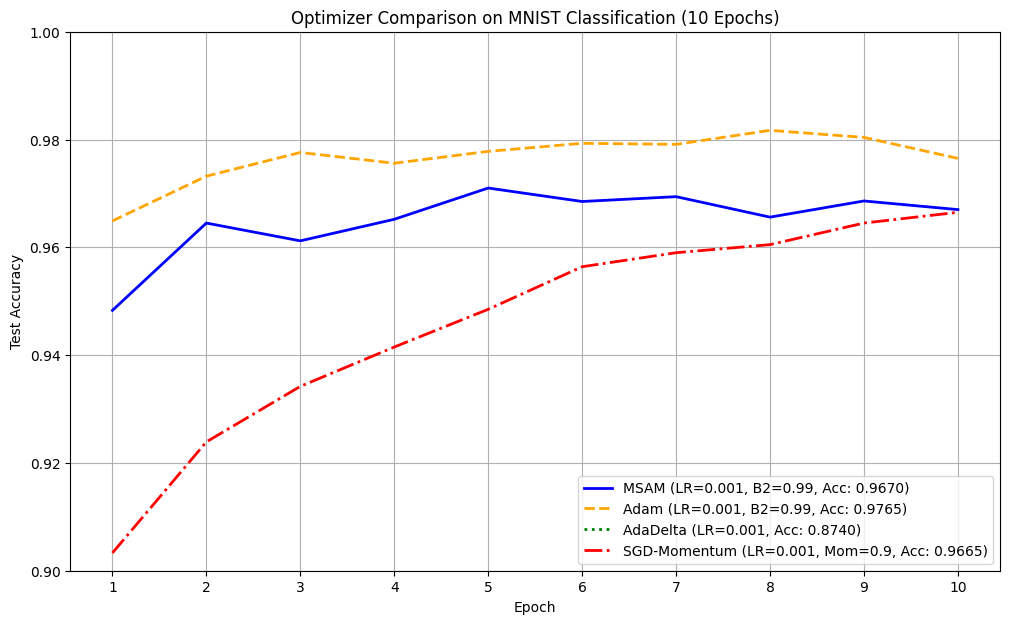

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 64

CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.99)
ADAM_DEFAULT_EPS = 1e-8

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001
SGD_MOM_DEFAULT_MOMENTUM = 0.9

class MSAM(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(MSAM, self).__init__(params, defaults)
        self.iterations = 0

    @torch.no_grad()
    def step(self):
        self.iterations += 1
        
        for group in self.param_groups:
            lr, beta1, beta2 = group["lr"], group["betas"][0], group["betas"][1]
            eps = group["eps"]
            
            t = self.iterations

            denom_b1 = 1.0 - beta1 ** t
            denom_b2 = 1.0 - beta2 ** t
            
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad

                state = self.state[p]

                if "m" not in state:
                    state["m"] = torch.zeros_like(p) 
                if "v" not in state:
                    state["v"] = torch.zeros_like(p) 

                m = state["m"]
                v = state["v"]

                m.mul_(beta1).add_(grad, alpha=(1.0 - beta1))

                m_squared = m.pow(2)
                v.mul_(beta2).add_(m_squared, alpha=(1.0 - beta2))

                mhat = m / denom_b1
                vhat = v / denom_b2

                p.addcdiv_(mhat, (vhat.sqrt() + eps), value=-lr)


class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        x = x.view(-1, 784) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)

def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, predicted = out.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return correct / total

def train(model, optimizer, name, params_info):
    model.train()
    acc_list = []
    
    param_str = ", ".join(f"{k.upper()}={v}" for k, v in params_info.items())
    print(f"\n=== Training {name} ({param_str}) ===")

    for epoch in range(1, EPOCHS + 1):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

        test_acc = test(model, test_loader)
        acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{EPOCHS} → Test Acc: {test_acc:.4f}")

    return acc_list


results = {}

# 1. MSAM Test
model_msam = SimpleNet().to(device)
optimizer_msam = MSAM(model_msam.parameters(), lr=CUSTOM_LR, betas=CUSTOM_BETAS, eps=CUSTOM_EPS)
results['MSAM'] = train(model_msam, optimizer_msam, name='MSAM', 
                        params_info={'lr': CUSTOM_LR, 'b1': CUSTOM_BETAS[0], 'b2': CUSTOM_BETAS[1]})

# 2. Adam Test
model_adam = SimpleNet().to(device)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=ADAM_DEFAULT_LR, betas=ADAM_DEFAULT_BETAS, eps=ADAM_DEFAULT_EPS)
results['Adam'] = train(model_adam, optimizer_adam, name='Adam (Default)', 
                        params_info={'lr': ADAM_DEFAULT_LR, 'b1': ADAM_DEFAULT_BETAS[0], 'b2': ADAM_DEFAULT_BETAS[1]})

# 3. AdaDelta Test
model_adadelta = SimpleNet().to(device)
optimizer_adadelta = torch.optim.Adadelta(model_adadelta.parameters(), lr=ADADELTA_DEFAULT_LR, rho=ADADELTA_DEFAULT_RHO, eps=ADADELTA_DEFAULT_EPS)
results['AdaDelta'] = train(model_adadelta, optimizer_adadelta, name='AdaDelta (Default)', 
                            params_info={'lr': ADADELTA_DEFAULT_LR, 'rho': ADADELTA_DEFAULT_RHO})

# 4. SGD-Momentum Test
model_sgd_mom = SimpleNet().to(device)
optimizer_sgd_mom = torch.optim.SGD(model_sgd_mom.parameters(), lr=SGD_MOM_DEFAULT_LR, momentum=SGD_MOM_DEFAULT_MOMENTUM)
results['SGD-Momentum'] = train(model_sgd_mom, optimizer_sgd_mom, name='SGD-Momentum (Default)', 
                                params_info={'lr': SGD_MOM_DEFAULT_LR, 'momentum': SGD_MOM_DEFAULT_MOMENTUM})


final_msam_acc = results['MSAM'][-1]
final_adam_acc = results['Adam'][-1]
final_adadelta_acc = results['AdaDelta'][-1]
final_sgd_mom_acc = results['SGD-Momentum'][-1]


print("MNIST Optimization Final Results (10 Epochs)")
print("==============================================")
print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Final Test Accuracy: {final_msam_acc:.4f}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Final Test Accuracy: {final_adam_acc:.4f}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Final Test Accuracy: {final_adadelta_acc:.4f}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Mom={SGD_MOM_DEFAULT_MOMENTUM}) Final Test Accuracy: {final_sgd_mom_acc:.4f}")

plt.figure(figsize=(12, 7))

plt.plot(range(1, EPOCHS + 1), results['MSAM'], 
           label=f'MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}, Acc: {final_msam_acc:.4f})', linewidth=2, color='blue')
plt.plot(range(1, EPOCHS + 1), results['Adam'], 
           label=f'Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}, Acc: {final_adam_acc:.4f})', linestyle='--', linewidth=2, color='orange')
plt.plot(range(1, EPOCHS + 1), results['AdaDelta'], 
           label=f'AdaDelta (LR={ADADELTA_DEFAULT_LR}, Acc: {final_adadelta_acc:.4f})', linestyle=':', linewidth=2, color='green')
plt.plot(range(1, EPOCHS + 1), results['SGD-Momentum'], 
           label=f'SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Mom={SGD_MOM_DEFAULT_MOMENTUM}, Acc: {final_sgd_mom_acc:.4f})', linestyle='-.', linewidth=2, color='red')

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title(f"Optimizer Comparison on MNIST Classification (10 Epochs)")
plt.legend(loc='lower right')
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))
plt.ylim(0.9, 1.0) 
plt.show()